<a href="https://colab.research.google.com/github/ChitrarthVasdev/PROJECT-Customer-Lifetime-Value-Prediction-Model/blob/main/Project_CLV_Prediction_Code_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load dataset
df = pd.read_excel("/content/Online Retail.xlsx")

# Remove rows with missing CustomerID
df = df[df['CustomerID'].notnull()]

# Remove canceled orders (InvoiceNo starts with "C")
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a new column for TotalAmount
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


In [8]:
df.head(15)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom,54.08


In [7]:
df.to_csv("Updated_Online_Retail.csv", index=True)


In [9]:
import datetime as dt

# Reference date is the day after the last invoice
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Aggregate features per customer
customer_df = df.groupby('CustomerID').agg({
    'InvoiceDate': [lambda x: (ref_date - x.max()).days, 'nunique'],
    'TotalAmount': 'sum'
})

# Rename columns
customer_df.columns = ['Recency', 'Frequency', 'Monetary']
customer_df['AOV'] = customer_df['Monetary'] / customer_df['Frequency']

# Define target variable as LTV (can be refined later)
customer_df['LTV'] = customer_df['Monetary']


In [11]:
customer_df.head(10)

,Recency,Frequency,Monetary,AOV,LTV
CustomerID,,,,,
12346.0,326,1,77183.60,77183.600000,77183.60
12347.0,2,7,4310.00,615.714286,4310.00
12348.0,75,4,1797.24,449.310000,1797.24
12349.0,19,1,1757.55,1757.550000,1757.55
12350.0,310,1,334.40,334.400000,334.40
12352.0,36,8,2506.04,313.255000,2506.04
12353.0,204,1,89.00,89.000000,89.00
12354.0,232,1,1079.40,1079.400000,1079.40
12355.0,214,1,459.40,459.400000,459.40


In [12]:
customer_df.to_csv("Updated_table.csv", index=True)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Features and Target
X = customer_df[['Recency', 'Frequency', 'AOV']]
y = customer_df['LTV']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 198.86
RMSE: 2622.26


In [26]:
# Predict LTV for all
customer_df['Predicted_LTV'] = model.predict(X)

# Segment customers into 4 groups
customer_df['Segment'] = pd.qcut(customer_df['Predicted_LTV'], q=4,
                                  labels=['Low', 'Mid-Low', 'Mid-High', 'High',])


In [15]:
# Save predictions to CSV
customer_df.to_csv("Predicted_LTV_Segments.csv", index=True)


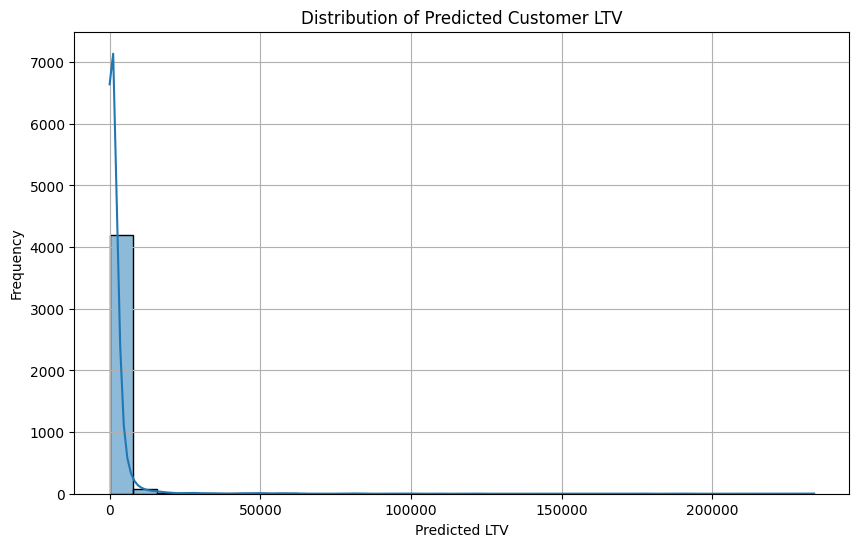

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(customer_df['Predicted_LTV'], kde=True, bins=30)
plt.title('Distribution of Predicted Customer LTV')
plt.xlabel('Predicted LTV')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("LTV_Prediction_Distribution.png")
plt.show()


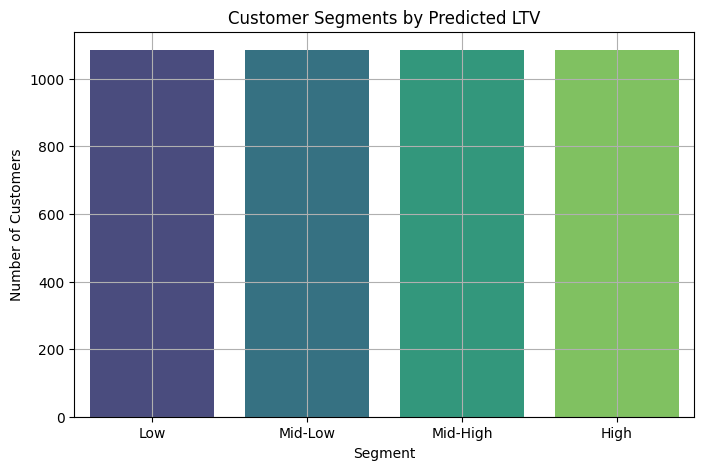

In [28]:
plt.figure(figsize=(8, 5))
sns.countplot(data=customer_df, x='Segment', hue='Segment', order=['Low', 'Mid-Low', 'Mid-High', 'High',], palette='viridis', legend=False)
plt.title('Customer Segments by Predicted LTV')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.savefig("Customer_Segment_Counts.png")
plt.show()


In [18]:
import joblib
joblib.dump(model, "LTV_model.pkl")


['LTV_model.pkl']